In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import global_params as G
plt.rcParams['figure.figsize'] = G.SMALL_FIG

In [3]:
import numpy as np
from scipy import signal
from scipy.fftpack import fft

np.set_printoptions(precision=4, suppress=True)

In [4]:
from wavegen import srrc, sine_wave
from transmitter import oversample
from receiver import quantalph, pulse_correlator
from sampling import interpolate

## 12.3 Decision Directed Timing Recovery

In [5]:
# Transmission Parameters
N = 10000//2 # num symbols
M = 2 # oversampling factor
alphabet = np.array([-3, -1, 1, 3]) # 4-PAM

# SRRC parameters
half_len = 50
beta = 0.3 # Roll-off for square root raised cosine
timing_offset = -0.2

# Channel
channel = np.array([1.]) 

In [6]:
# Transmitted signal
symbols = np.random.choice(alphabet, N) # 4-PAM
pulse = srrc(half_len, M, beta, timing_offset)

oversampled = oversample(symbols, M)
analog = np.convolve(oversampled, pulse)
received = np.convolve(analog, channel)

# Receiver
# Wrapper for srrc pulse
def rx_srrc_pulse(osr):
    return srrc(half_len, osr, beta, 0)

matched_out = pulse_correlator(received, M, rx_srrc_pulse)

CPU times: user 2.26 s, sys: 15 ms, total: 2.27 s
Wall time: 2.31 s


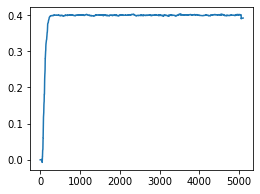

In [7]:
%%time
# Clock recovery parameters
mu = 0.01
delta = 0.1 # for derivative calculation

# Initialization
tau = 0
tau_history = [0]
sample_history = []
t_now = half_len * M
# Run loop
while t_now < len(matched_out) - half_len*M:
    sample = interpolate(matched_out, t_now+tau, half_len)
    sample_right = interpolate(matched_out, t_now + tau + delta, half_len)
    sample_left = interpolate(matched_out, t_now + tau - delta, half_len)
    deriv = (sample_right - sample_left)/(2*delta) 
    decision = quantalph(sample, alphabet)[0]
    # Updates
    tau = tau + mu * deriv * (decision - sample)
    t_now += M
    # Save history 
    sample_history.append(sample)
    tau_history.append(tau)
    
plt.plot(tau_history);

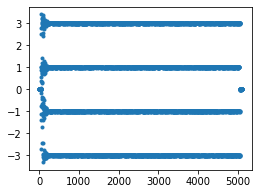

In [8]:
plt.plot(sample_history, '.');